**Import packages**

In [1]:
!pip install pytictoc

In [2]:
!pip install tensorflow

In [3]:
import random
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd
from pytictoc import TicToc
warnings.filterwarnings( "ignore" )

**Load the dataset**

In [4]:
(X_train, y_train), (X_test,y_test) = datasets.mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

**Create helper functions**

In [5]:
def plot_sample_image(X, y):
    plt.figure(figsize = (15,2))
    plt.imshow(X); plt.colorbar();
    classes = ["0","1","2","3","4","5","6","7","8","9"]
    plt.xlabel('Image Label: {}'.format(classes[y]))

def classification_results(X_test,y_test,y_pred_classes):
  from sklearn.metrics import confusion_matrix , classification_report
  import seaborn as sn

  cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_classes)
  plt.figure(figsize = (7,5))
  sn.heatmap(cm, annot=True, fmt='d', cmap='Greens')
  plt.xlabel('Predicted');
  plt.ylabel('Truth');

  print("Classification Report: \n", classification_report(y_test, y_pred_classes))

def plot_fitting_history(history,filename,dpi):
  epochs = len(history.history['loss'])
  epoch_data = np.arange(1,epochs+1)
  plt.plot(epoch_data,history.history['loss'],'o-')
  plt.plot(epoch_data,history.history['val_loss'],'o--')
  plt.ylabel('Loss')
  plt.xlabel('Epoch sequence' )
  plt.xticks(np.arange(0, epochs + 1, step=1))
  plt.legend(['Training','Validation'])
  plt.savefig(filename, dpi=dpi)
  plt.show()

**Plot sample image**

**Normalize the input data**

In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0

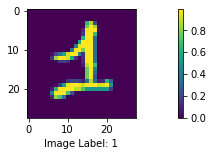

In [7]:
index = np.random.randint(100)
plot_sample_image(X_train[index], y_train[index]);

In [8]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/MyDrive/ECE 696B/Project - ECE696B

**Load the models**

In [12]:
%cd C:\Users\nh202\My Drive (nh202@arizona.edu)\ECE 696B\Project - ECE696B
from keras.models import load_model
Linear_MNIST = load_model('Linear_MNIST.h5')
MLP_MNIST = load_model('MLP_MNIST.h5')
CNN_MNIST = load_model('CNN_MNIST.h5')

C:\Users\nh202\My Drive (nh202@arizona.edu)\ECE 696B\Project - ECE696B


# Fast gradient sign method (FGSM) attack

**Function for FGSM attack**

In [11]:
def fgsm_attack(model, x, y_true, eps):

    if len(x.shape) == 2:
        # Create a tensor for the input image to make it compatible with the tensor shape expected by the model
        x_tensor = tf.convert_to_tensor(x[np.newaxis, ...])
    if len(x.shape) == 3:
        x_tensor = tf.convert_to_tensor(x)
    
    # Set tape to watch the input tensor
    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        y_pred = model(x_tensor)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)  
    
    # Calculate the gradient of the loss with respect to the input image
    grads = tape.gradient(loss, x_tensor)
    
    # Calculate the sign of the gradient
    if len(x.shape) == 2:
        x_adv = x + eps * sign[0]
    if len(x.shape) == 3:
        x_adv = x + eps * sign

    # Notes:
    # sign[0] matches the shape of x, sign matches the shape of x_tensor
    # print(sign[0].shape, x.shape, sign.shape, x_tensor.shape)
    
    # Generate the adversarial example by adding the sign of the gradient times epsilon to the input image
    x_adv = x + eps * sign
    
    # Clip the adversarial example to maintain pixel values in [0,1] range
    x_adv = tf.clip_by_value(x_adv, clip_value_min=0, clip_value_max=1)
    
    return x_adv.numpy()

**Evaluate test accuracy on unperturbed vs perturbed data**

In [13]:
indexes = range(1000)
print('Test accuracy on unperturbed data')
Linear_MNIST.evaluate(X_test[indexes],y_test[indexes])
MLP_MNIST.evaluate(X_test[indexes],y_test[indexes])
CNN_MNIST.evaluate(X_test[indexes],y_test[indexes])
print('\n')

Test accuracy on unperturbed data
32/32 [==============================] - 1s 6ms/step - loss: 0.0597 - accuracy: 0.9790




In [14]:
%cd C:\Users\nh202\OneDrive - University of Arizona\Adversairal Examples - ECE 696B\FGSM

C:\Users\nh202\OneDrive - University of Arizona\Adversairal Examples - ECE 696B\FGSM


**Create adversarial examples**

In [13]:
for eps in np.arange(0.1,1.1,0.1):
    
  print(f'eps value: {np.round(eps,1)}')

  t = TicToc()
  t.tic()
  X_test_FGSM_Linear = fgsm_attack(Linear_MNIST,X_test[indexes],y_test[indexes],eps)
  print('X_test_FGSM_Linear is complete')
  X_test_FGSM_MLP = fgsm_attack(MLP_MNIST,X_test[indexes],y_test[indexes],eps)
  print('X_test_FGSM_MLP is complete')
  X_test_FGSM_CNN = fgsm_attack(CNN_MNIST,X_test[indexes],y_test[indexes],eps)
  print('X_test_FGSM_CNN is complete')
  t.toc()

  # Save the adversarial examples
  np_array_filename = 'MNIST_FGSM_'+ str(len(indexes)) +'_adv_examples_eps_'+ str(round(eps,1)) + '.npz'
  np.savez(np_array_filename, X_test_FGSM_Linear=X_test_FGSM_Linear, \
          X_test_FGSM_MLP=X_test_FGSM_MLP, X_test_FGSM_CNN=X_test_FGSM_CNN)

  stored_results = []
  print('\n')
  print('Test accuracy on perturbed data targeted for Linear model')
  avg_l2_norm_Linear = np.mean(np.sqrt(np.sum((X_test_FGSM_Linear-X_test[:len(indexes)])**2, axis=(1,2))))
  stored_results.append(avg_l2_norm_Linear)
  _, accuracy = Linear_MNIST.evaluate(X_test_FGSM_Linear[indexes],y_test[indexes])
  stored_results.append(accuracy)
  _, accuracy = MLP_MNIST.evaluate(X_test_FGSM_Linear[indexes],y_test[indexes])
  stored_results.append(accuracy)
  _, accuracy = CNN_MNIST.evaluate(X_test_FGSM_Linear[indexes],y_test[indexes])
  stored_results.append(accuracy)
  print('\n')
  print('Test accuracy on perturbed data targeted for MLP model')
  avg_l2_norm_MLP = np.mean(np.sqrt(np.sum((X_test_FGSM_MLP-X_test[:len(indexes)])**2, axis=(1,2))))
  stored_results.append(avg_l2_norm_MLP)
  _, accuracy = Linear_MNIST.evaluate(X_test_FGSM_MLP[indexes],y_test[indexes])
  stored_results.append(accuracy)
  _, accuracy = MLP_MNIST.evaluate(X_test_FGSM_MLP[indexes],y_test[indexes])
  stored_results.append(accuracy)
  _, accuracy = CNN_MNIST.evaluate(X_test_FGSM_MLP[indexes],y_test[indexes])
  stored_results.append(accuracy)
  print('\n')
  print('Test accuracy on perturbed data targeted for CNN model')
  avg_l2_norm_CNN = np.mean(np.sqrt(np.sum((X_test_FGSM_CNN-X_test[:len(indexes)])**2, axis=(1,2))))
  stored_results.append(avg_l2_norm_CNN)
  _, accuracy = Linear_MNIST.evaluate(X_test_FGSM_CNN[indexes],y_test[indexes])
  stored_results.append(accuracy)
  _, accuracy = MLP_MNIST.evaluate(X_test_FGSM_CNN[indexes],y_test[indexes])
  stored_results.append(accuracy)
  _, accuracy = CNN_MNIST.evaluate(X_test_FGSM_CNN[indexes],y_test[indexes])
  stored_results.append(accuracy)
  print()

  stored_results = np.array(stored_results)
  stored_results = stored_results.reshape(-1,4)
  df = pd.DataFrame(stored_results, columns = ['avg_l2_norm','Linear_MNIST_test_accuray',\
                                   'MLP_MNIST_test_accuray','CNN_MNIST_test_accuray'])

  filename = 'Adversarial_Attacks_MNIST_'+ str(len(indexes)) +' [FGSM Attack - eps '+ str(round(eps,1)) + '].csv'
  df.to_csv(filename, index=False)

eps value: 0.1
X_test_FGSM_Linear is complete
X_test_FGSM_MLP is complete
X_test_FGSM_CNN is complete
Elapsed time is 0.299820 seconds.


Test accuracy on perturbed data targeted for Linear model
32/32 [==============================] - 0s 3ms/step - loss: 0.2275 - accuracy: 0.9300


Test accuracy on perturbed data targeted for MLP model
32/32 [==============================] - 0s 3ms/step - loss: 0.2175 - accuracy: 0.9340


Test accuracy on perturbed data targeted for CNN model
32/32 [==============================] - 0s 3ms/step - loss: 2.6504 - accuracy: 0.4390

eps value: 0.2
X_test_FGSM_Linear is complete
X_test_FGSM_MLP is complete
X_test_FGSM_CNN is complete
Elapsed time is 0.218768 seconds.


Test accuracy on perturbed data targeted for Linear model
32/32 [==============================] - 0s 3ms/step - loss: 1.5958 - accuracy: 0.6410


Test accuracy on perturbed data targeted for MLP model
32/32 [==============================] - 0s 3ms/step - loss: 1.3776 - accuracy: 0.6610



**Load the adversarial examples**

In [14]:
np_array_filename = 'MNIST_FGSM_'+ str(len(indexes)) +'_adv_examples_eps_'+ str(round(eps,1)) + '.npz'
data = np.load(np_array_filename)

# access the arrays using their keys
X_test_FGSM_Linear = data['X_test_FGSM_Linear']
X_test_FGSM_MLP = data['X_test_FGSM_MLP']
X_test_FGSM_CNN = data['X_test_FGSM_CNN']

print('Test accuracy on unperturbed data')
Linear_MNIST.evaluate(X_test[indexes],y_test[indexes])
MLP_MNIST.evaluate(X_test[indexes],y_test[indexes])
CNN_MNIST.evaluate(X_test[indexes],y_test[indexes])
print('\n')
print('Test accuracy on perturbed data targeted for Linear model')
Linear_MNIST.evaluate(X_test_FGSM_Linear[indexes],y_test[indexes])
MLP_MNIST.evaluate(X_test_FGSM_Linear[indexes],y_test[indexes])
CNN_MNIST.evaluate(X_test_FGSM_Linear[indexes],y_test[indexes])
print('\n')
print('Test accuracy on perturbed data targeted for MLP model')
Linear_MNIST.evaluate(X_test_FGSM_MLP[indexes],y_test[indexes])
MLP_MNIST.evaluate(X_test_FGSM_MLP[indexes],y_test[indexes])
CNN_MNIST.evaluate(X_test_FGSM_MLP[indexes],y_test[indexes])
print('\n')
print('Test accuracy on perturbed data targeted for CNN model')
Linear_MNIST.evaluate(X_test_FGSM_CNN[indexes],y_test[indexes])
MLP_MNIST.evaluate(X_test_FGSM_CNN[indexes],y_test[indexes])
CNN_MNIST.evaluate(X_test_FGSM_CNN[indexes],y_test[indexes])
print()

Test accuracy on unperturbed data
32/32 [==============================] - 0s 3ms/step - loss: 0.0597 - accuracy: 0.9790


Test accuracy on perturbed data targeted for Linear model
32/32 [==============================] - 0s 4ms/step - loss: 63.2569 - accuracy: 0.0010


Test accuracy on perturbed data targeted for MLP model
32/32 [==============================] - 0s 3ms/step - loss: 55.9602 - accuracy: 0.0090


Test accuracy on perturbed data targeted for CNN model
32/32 [==============================] - 0s 3ms/step - loss: 45.1943 - accuracy: 0.0430



**Visualize the effect of the added noise**

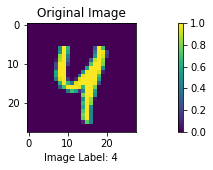

1/1 [==============================] - 0s 25ms/step


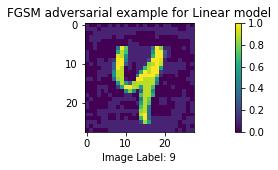

1/1 [==============================] - 0s 27ms/step


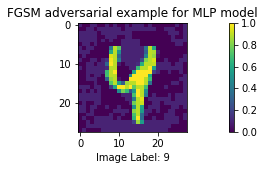

1/1 [==============================] - 0s 20ms/step


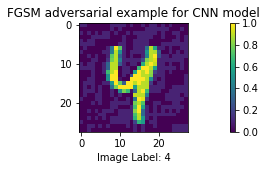

In [23]:
np_array_filename = 'MNIST_FGSM_'+ str(len(indexes)) +'_adv_examples_eps_'+ str(round(0.1,1)) + '.npz'
data = np.load(np_array_filename)

# access the arrays using their keys
X_test_FGSM_Linear = data['X_test_FGSM_Linear']
X_test_FGSM_MLP = data['X_test_FGSM_MLP']
X_test_FGSM_CNN = data['X_test_FGSM_CNN']

index = np.random.randint(100)
plot_sample_image(X_test[index], y_test[index])
plt.title('Original Image'); plt.show()
plot_sample_image(X_test_FGSM_Linear[index], np.argmax(Linear_MNIST.predict(X_test_FGSM_Linear[index][np.newaxis, ...])))
plt.title('FGSM adversarial example for Linear model'); plt.show()
plot_sample_image(X_test_FGSM_MLP[index], np.argmax(MLP_MNIST.predict(X_test_FGSM_Linear[index][np.newaxis, ...])))
plt.title('FGSM adversarial example for MLP model'); plt.show()
plot_sample_image(X_test_FGSM_CNN[index], np.argmax(CNN_MNIST.predict(X_test_FGSM_Linear[index][np.newaxis, ...])))
plt.title('FGSM adversarial example for CNN model'); plt.show()

# Compile the results into a dataframe

In [17]:
target_models = []
for i in range(10):
    target_models.append('Linear')
    target_models.append('MLP')    
    target_models.append('CNN') 
target_models = np.array(target_models).reshape(-1,1)

In [18]:
eps_values = []
for eps in np.arange(0.1,1.1,0.1):
    eps_values.append(eps)
    eps_values.append(eps)    
    eps_values.append(eps) 
eps_values = np.array(eps_values).reshape(-1,1)

In [19]:
df_all = pd.DataFrame()
for eps in np.arange(0.1,1.1,0.1):
    filename = 'Adversarial_Attacks_MNIST_'+ str(len(indexes)) +' [FGSM Attack - eps '+ str(round(eps,1)) + '].csv'
    df = pd.read_csv(filename)
    df_all = pd.concat([df_all, df], ignore_index=True)
df_all['Target model'] = target_models
df_all['eps value'] = eps_values
df_all = df_all[['eps value', 'Target model', 'avg_l2_norm', 'Linear_MNIST_test_accuray', 'MLP_MNIST_test_accuray',
       'CNN_MNIST_test_accuray']]
df_all.to_csv('Adversarial_Attacks_MNIST [FGSM Attack].csv', index=False)
df_all

,eps value,Target model,avg_l2_norm,Linear_MNIST_test_accuray,MLP_MNIST_test_accuray,CNN_MNIST_test_accuray
0,0.1,Linear,2.104669,0.002,0.224,0.930
1,0.1,MLP,2.130851,0.138,0.059,0.934
2,0.1,CNN,2.139995,0.718,0.797,0.439
3,0.2,Linear,4.174779,0.000,0.013,0.641
4,0.2,MLP,4.227887,0.024,0.013,0.661
5,0.2,CNN,4.248348,0.359,0.522,0.152
6,0.3,Linear,6.217968,0.000,0.000,0.323
7,0.3,MLP,6.298463,0.005,0.003,0.334
8,0.3,CNN,6.331492,0.247,0.334,0.091
9,0.4,Linear,8.237682,0.000,0.000,0.149


# Prepare the plots

Test accuracy on unperturbed data
32/32 [==============================] - 0s 7ms/step - loss: 0.0597 - accuracy: 0.9790


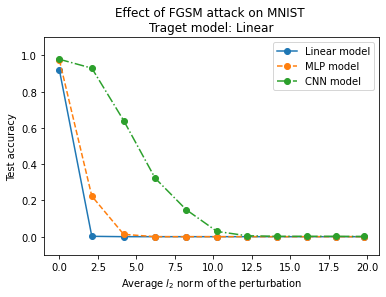

In [15]:
df_all = pd.read_csv('Adversarial_Attacks_MNIST [FGSM Attack].csv')
df_Linear = df_all[df_all['Target model']=='Linear']
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
df_Linear.loc[10] = [0, '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df_Linear
df_Linear = df_Linear.sort_values('avg_l2_norm', ascending=True)
plt.plot(df_Linear['avg_l2_norm'],df_Linear['Linear_MNIST_test_accuray'],'o-')
plt.plot(df_Linear['avg_l2_norm'],df_Linear['MLP_MNIST_test_accuray'],'o--')
plt.plot(df_Linear['avg_l2_norm'],df_Linear['CNN_MNIST_test_accuray'],'o-.')
plt.xlabel('Average $l_2$ norm of the perturbation')
plt.ylabel('Test accuracy')
plt.ylim([-0.1, 1.1])
plt.legend(['Linear model', 'MLP model','CNN model'])
plt.title('Effect of FGSM attack on MNIST \nTraget model: Linear')
plt.savefig('Effect of FGSM attack on MNIST for Linear model [l2 norm]', dpi=600)
plt.show()

Test accuracy on unperturbed data
32/32 [==============================] - 0s 6ms/step - loss: 0.0597 - accuracy: 0.9790


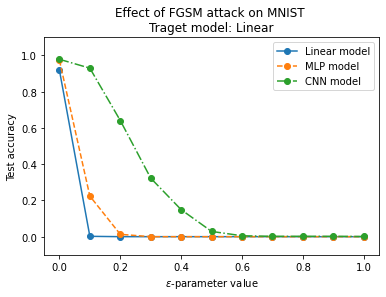

In [16]:
df_all = pd.read_csv('Adversarial_Attacks_MNIST [FGSM Attack].csv')
df_Linear = df_all[df_all['Target model']=='Linear']
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
df_Linear.loc[10] = [0, '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df_Linear
df_Linear = df_Linear.sort_values('eps value', ascending=True)
plt.plot(df_Linear['eps value'],df_Linear['Linear_MNIST_test_accuray'],'o-')
plt.plot(df_Linear['eps value'],df_Linear['MLP_MNIST_test_accuray'],'o--')
plt.plot(df_Linear['eps value'],df_Linear['CNN_MNIST_test_accuray'],'o-.')
plt.xlabel('$\epsilon$-parameter value')
plt.ylabel('Test accuracy')
plt.ylim([-0.1, 1.1])
plt.legend(['Linear model', 'MLP model','CNN model'])
plt.title('Effect of FGSM attack on MNIST \nTraget model: Linear')
plt.savefig('Effect of FGSM attack on MNIST for Linear model [eps value]', dpi=600)
plt.show()

Test accuracy on unperturbed data
32/32 [==============================] - 0s 6ms/step - loss: 0.0597 - accuracy: 0.9790


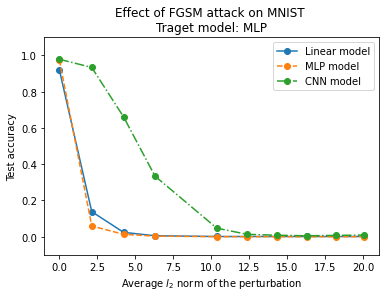

In [17]:
df_all = pd.read_csv('Adversarial_Attacks_MNIST [FGSM Attack].csv')
df_MLP = df_all[df_all['Target model']=='MLP']
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
df_MLP.loc[10] = [0, '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df_MLP
df_MLP = df_MLP.sort_values('avg_l2_norm', ascending=True)
plt.plot(df_MLP['avg_l2_norm'],df_MLP['Linear_MNIST_test_accuray'],'o-')
plt.plot(df_MLP['avg_l2_norm'],df_MLP['MLP_MNIST_test_accuray'],'o--')
plt.plot(df_MLP['avg_l2_norm'],df_MLP['CNN_MNIST_test_accuray'],'o-.')
plt.xlabel('Average $l_2$ norm of the perturbation')
plt.ylabel('Test accuracy')
plt.ylim([-0.1, 1.1])
plt.legend(['Linear model', 'MLP model','CNN model'])
plt.title('Effect of FGSM attack on MNIST \nTraget model: MLP')
plt.savefig('Effect of FGSM attack on MNIST for MLP model [l2 norm]', dpi=600)
plt.show()

Test accuracy on unperturbed data
32/32 [==============================] - 0s 6ms/step - loss: 0.0597 - accuracy: 0.9790


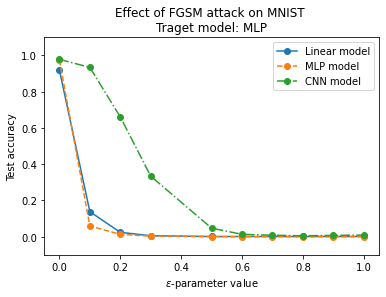

In [20]:
df_all = pd.read_csv('Adversarial_Attacks_MNIST [FGSM Attack].csv')
df_MLP = df_all[df_all['Target model']=='MLP']
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
df_MLP.loc[10] = [0, '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df_MLP
df_MLP = df_MLP.sort_values('eps value', ascending=True)
plt.plot(df_MLP['eps value'],df_MLP['Linear_MNIST_test_accuray'],'o-')
plt.plot(df_MLP['eps value'],df_MLP['MLP_MNIST_test_accuray'],'o--')
plt.plot(df_MLP['eps value'],df_MLP['CNN_MNIST_test_accuray'],'o-.')
plt.xlabel('$\epsilon$-parameter value')
plt.ylabel('Test accuracy')
plt.ylim([-0.1, 1.1])
plt.legend(['Linear model', 'MLP model','CNN model'])
plt.title('Effect of FGSM attack on MNIST \nTraget model: MLP')
plt.savefig('Effect of FGSM attack on MNIST for MLP model [eps value]', dpi=600)
plt.show()

Test accuracy on unperturbed data
32/32 [==============================] - 0s 8ms/step - loss: 0.0597 - accuracy: 0.9790


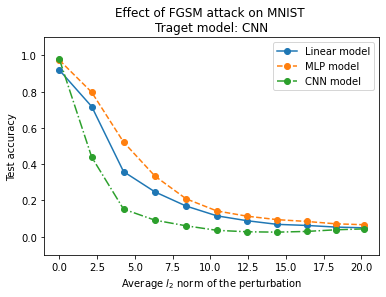

In [18]:
df_all = pd.read_csv('Adversarial_Attacks_MNIST [FGSM Attack].csv')
df_CNN = df_all[df_all['Target model']=='CNN']
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
df_CNN.loc[10] = [0, '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df_CNN
df_CNN = df_CNN.sort_values('avg_l2_norm', ascending=True)
plt.plot(df_CNN['avg_l2_norm'],df_CNN['Linear_MNIST_test_accuray'],'o-')
plt.plot(df_CNN['avg_l2_norm'],df_CNN['MLP_MNIST_test_accuray'],'o--')
plt.plot(df_CNN['avg_l2_norm'],df_CNN['CNN_MNIST_test_accuray'],'o-.')
plt.xlabel('Average $l_2$ norm of the perturbation')
plt.ylabel('Test accuracy')
plt.ylim([-0.1, 1.1])
plt.legend(['Linear model', 'MLP model','CNN model'])
plt.title('Effect of FGSM attack on MNIST \nTraget model: CNN')
plt.savefig('Effect of FGSM attack on MNIST for CNN model [l2 norm]', dpi=600)
plt.show()

Test accuracy on unperturbed data
32/32 [==============================] - 0s 6ms/step - loss: 0.0597 - accuracy: 0.9790


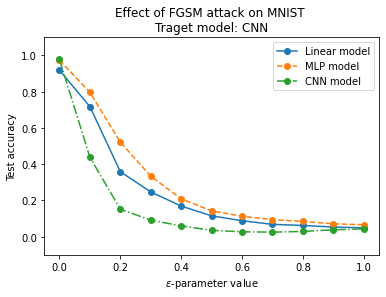

In [19]:
df_all = pd.read_csv('Adversarial_Attacks_MNIST [FGSM Attack].csv')
df_CNN = df_all[df_all['Target model']=='CNN']
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
df_CNN.loc[10] = [0, '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df_CNN
df_CNN = df_CNN.sort_values('eps value', ascending=True)
plt.plot(df_CNN['eps value'],df_CNN['Linear_MNIST_test_accuray'],'o-')
plt.plot(df_CNN['eps value'],df_CNN['MLP_MNIST_test_accuray'],'o--')
plt.plot(df_CNN['eps value'],df_CNN['CNN_MNIST_test_accuray'],'o-.')
plt.xlabel('$\epsilon$-parameter value')
plt.ylabel('Test accuracy')
plt.ylim([-0.1, 1.1])
plt.legend(['Linear model', 'MLP model','CNN model'])
plt.title('Effect of FGSM attack on MNIST \nTraget model: CNN')
plt.savefig('Effect of FGSM attack on MNIST for CNN model [eps value]', dpi=600)
plt.show()